In [1]:
!date

Tue Jul  1 06:49:18 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
%%time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model
from torch.autograd import Function

CPU times: user 1.63 s, sys: 672 ms, total: 2.31 s
Wall time: 3.52 s


In [4]:
import ants # ANTSpy in the toolbox for manipulating MRI files 
from tqdm import tqdm # Easy progress bars
import seaborn as sns

In [5]:
import sys
from IPython import display
import pickle

In [6]:
from nilearn.glm.first_level import make_first_level_design_matrix

In [7]:
print(np.__version__)
print(sklearn.__version__)
print(torch.__version__)
print(ants.__version__)

1.20.1
1.3.2
2.4.1+cu121
0.5.4


In [8]:
def correlation(x,y):
  x_mean = np.repeat(x.mean(),x.shape,axis=0)
  y_mean = np.repeat(y.mean(),y.shape,axis=0)
  cov = (x-x_mean)*(y-y_mean)
  r = cov.sum()/(x.std()*y.std()*x.shape[0])
  return r

def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

def compute_in(x):
  return (x-3)/2+1

def compute_in_size(x):
  for i in range(4):
    x = compute_in(x)
  return x

def compute_out_size(x):
  return ((((x*2+1)*2+1)*2+1)*2+1)

def compute_padding(x):
  rounding = np.ceil(compute_in_size(x))-compute_in_size(x)
  y = ((((rounding*2)*2)*2)*2)
  pad = bin(int(y)).replace('0b', '')
  if len(pad) < 4:
      for i in range(4-len(pad)):
          pad = '0' + pad
  final_size = compute_in_size(x+y)
  pad_out = bin(int(compute_out_size(final_size)-x)).replace('0b','')
  if len(pad_out) < 4:
      for i in range(4-len(pad_out)):
          pad_out = '0' + pad_out
  return pad,final_size, pad_out

In [9]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.obs = X
    self.noi = Y

  def __len__(self):
    return min(self.obs.shape[0],self.noi.shape[0])

  def __getitem__(self, index):
    observation = self.obs[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise
    return observation, noise_aug

In [10]:
class cVAE(nn.Module):

    def __init__(self,conf,in_channels: int,in_dim: int, latent_dim: tuple,hidden_dims: List = None, beta : float = 1, gamma : float = 1, delta : float = 1, scale_MSE_GM : float = 1, scale_MSE_CF : float = 1, scale_MSE_FG : float = 1,do_disentangle = True, freq_exp : float = 1, freq_scale : float = 1) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.latent_dim_z = self.latent_dim[0]
        self.latent_dim_s = self.latent_dim[1]
        self.in_channels = in_channels
        self.in_dim = in_dim
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.scale_MSE_GM = scale_MSE_GM
        self.scale_MSE_CF = scale_MSE_CF
        self.do_disentangle = do_disentangle
        self.freq_exp = freq_exp
        self.freq_scale = freq_scale
        self.scale_MSE_FG = scale_MSE_FG
        self.confounds = conf.float()
        self.grl = GradientReversalLayer(lambda_=1.0)

        self.decoder_confounds_z = nn.Sequential(
        
                nn.ConvTranspose1d(in_channels=latent_dim[0], out_channels=128, 
                                   kernel_size=nTR, stride=1, bias=False),
            
                # First conv layer: convert 128 channels to 32 channels.
                nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Second conv layer: convert 32 channels to 16 channels.
                nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Third conv layer: convert 16 channels to 6 channels.
                nn.Conv1d(in_channels=16, out_channels=6, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Sigmoid()  # Normalize the output to [0, 1]
                    )


        self.decoder_confounds_s = nn.Sequential(
        
                nn.ConvTranspose1d(in_channels=latent_dim[1], out_channels=128, 
                                   kernel_size=nTR, stride=1, bias=False),
            
                # First conv layer: convert 128 channels to 32 channels.
                nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Second conv layer: convert 32 channels to 16 channels.
                nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(),
            
                # Third conv layer: convert 16 channels to 6 channels.
                nn.Conv1d(in_channels=16, out_channels=6, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Sigmoid()  # Normalize the output to [0, 1]
                    )

    

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)


        # Build Decoder
        modules = []

        #self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))
        self.decoder_input = nn.Linear(self.latent_dim_s+self.latent_dim_z, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.LeakyReLU()
                    )
            )


        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= self.in_channels,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]: # ORIGINAL
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        #output = self.decode(torch.cat((tg_z, tg_s),1))
        output = self.forward_bg(input)[0]+self.forward_fg(input)[0]
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        zeros = torch.zeros(tg_s.shape[0],self.latent_dim_z)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((zeros, tg_s),1))
        return  [output, input, tg_mu_s, tg_log_var_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_z, bg_log_var_z = self.encode_z(input)
        bg_z = self.reparameterize(bg_mu_z, bg_log_var_z)
        zeros = torch.zeros(bg_z.shape[0],self.latent_dim_s)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((bg_z, zeros),1))
        return  [output, input, bg_mu_z, bg_log_var_z]


    def ncc(self, x, y, eps = 1e-8):
        x = x.flatten(start_dim=1)  # Flatten spatial dimensions
        y = y.flatten(start_dim=1)

        x_mean = x.mean(dim=1, keepdim=True)
        y_mean = y.mean(dim=1, keepdim=True)

        x_std = x.std(dim=1, keepdim=True)
        y_std = y.std(dim=1, keepdim=True)

        ncc = (x - x_mean) * (y - y_mean) / (x_std * y_std + eps)
        ncc = ncc.mean(dim=1)

        return 1 - ncc  # Return 1 - NCC to minimize the loss 

    
        

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = self.beta
        gamma = self.gamma
        delta = self.delta
                          
        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_z = args[10]
        bg_log_var_z = args[11]
        
        recons_fg = self.forward_fg(input_tg)[0]
        
        
        # recons_loss_roi = F.mse_loss(recons_tg, input_tg) * self.scale_MSE_GM 
        # recons_loss_roni = F.mse_loss(recons_bg, input_bg) * self.scale_MSE_CF 
        recons_loss_roi = F.mse_loss(recons_tg[:,0,:], input_tg[:,0,:]) * self.scale_MSE_GM #/ batch_size # TG reconstrction loss
        recons_loss_roni = F.mse_loss(recons_bg[:,0,:], input_bg[:,0,:]) * self.scale_MSE_CF # / batch_size # BG reconstrction loss
        #recons_loss_roi+=F.mse_loss(recons_fg[:,0,:], input_tg[:,0,:]) * self.scale_MSE_GM*.01
        recons_loss = recons_loss_roi+recons_loss_roni

        
        

        #recons_loss_fg = F.mse_loss(torch.zeros_like(input_bg[:,0,:]), self.forward_fg(input_bg)[0][:,0,:])*1e2 # Denoised version of RONI, should be all zeros
        #recons_loss_fg+=F.mse_loss(torch.zeros_like(input_bg[:,0,:]), self.forward_bg(recons_fg)[0][:,0,:])*1e2 # Noise features of FG should be all zeros

        confounds_pred_z = self.decoder_confounds_z(torch.unsqueeze(tg_z,2))
        confounds_pred_s = self.decoder_confounds_s(torch.unsqueeze(tg_s,2))

        loss_recon_conf_s = self.grl(F.mse_loss(confounds_pred_s, self.confounds))*1e2
        loss_recon_conf_z = F.mse_loss(confounds_pred_z, self.confounds)*1e2

        ncc_loss_tg = self.ncc(input_tg,recons_tg).mean()*1
        ncc_loss_bg = self.ncc(input_bg,recons_bg).mean()*1

        ncc_loss_conf_s = 0
        for i in range(self.confounds.shape[1]):
            ncc_loss_conf_s +=  self.ncc(self.confounds[:,i,:],confounds_pred_s[:,i,:]).mean()*1e1
        ncc_loss_conf_s = self.grl(ncc_loss_conf_s)

        ncc_loss_conf_z = 0
        for i in range(self.confounds.shape[1]):
            ncc_loss_conf_z += self.ncc(self.confounds[:,i,:],confounds_pred_z[:,i,:]).mean()*1e1

        #ncc_loss_conf_s*=1e2
        #ncc_loss_conf_z*=1e2


        recond_bg = self.forward_bg(input_tg)[0]
        fg_bg_ncc = model.ncc(recond_bg[:,0,:],recons_fg[:,0,:]).mean()
        recons_loss_fg = F.mse_loss(torch.zeros_like(fg_bg_ncc), 1-fg_bg_ncc)*1e4
        
        
        recons_loss+=F.mse_loss(recons_fg[:,0,:], input_tg[:,0,:])*.0001
        recons_loss+=F.mse_loss(recons_bg[:,0,:], input_bg[:,0,:])*.00001

        smoothness_loss = torch.mean((recons_fg[:,0,:][:, 1:] - recons_fg[:,0,:][:, :-1])**2)
        smoothness_loss+=torch.mean((recond_bg[:,0,:][:, 1:] - recond_bg[:,0,:][:, :-1])**2)
        smoothness_loss*=.01
        
        #ncc_losses = ncc_loss_tg+ncc_loss_bg+ncc_loss_conf_s+ncc_loss_conf_z
    
        do_disentangle=self.do_disentangle # Whether to do disentagling 
        disentangle_type = -1 # What type of disentangling to d
        fg_volatility_loss = torch.from_numpy(np.array(0)).to(device)
        total_contrastive_loss = torch.from_numpy(np.array(0)).to(device)
        ncc_loss_conf_s = torch.from_numpy(np.array(0)).to(device)

        
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + bg_log_var_z - bg_mu_z ** 2 - bg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss = kld_loss/3
        kld_loss = kld_loss * beta
        

        #loss = torch.sum(recons_loss + kld_loss)
        #loss = torch.sum(recons_loss + kld_loss + recons_loss_fg)
        #loss = torch.sum(recons_loss + kld_loss + recons_loss_fg + ncc_loss_tg + ncc_loss_bg)
        loss = torch.sum(recons_loss + kld_loss + recons_loss_fg + ncc_loss_tg + ncc_loss_bg + loss_recon_conf_s + loss_recon_conf_z + recons_loss_fg + smoothness_loss + ncc_loss_conf_z + ncc_loss_conf_s)
        #loss = torch.sum(recons_loss + kld_loss + ncc_loss_tg + ncc_loss_bg + loss_recon_conf_s + loss_recon_conf_z + ncc_loss_conf_s + ncc_loss_conf_z + recons_loss_fg + smoothness_loss)
        #loss = torch.sum(recons_loss + kld_loss + loss_recon_conf_s + loss_recon_conf_z + ncc_loss_conf_s + +ncc_loss_conf_z +ncc_loss_tg + ncc_loss_bg + recons_loss_fg + smoothness_loss)
        

        return {
            'loss' : loss,
            'kld_loss' : kld_loss,
            'recons_loss_roi' : recons_loss_roi,
            'recons_loss_roni' : recons_loss_roni,
            'loss_recon_conf_s' : loss_recon_conf_s,
            'loss_recon_conf_z' : loss_recon_conf_z,
            'ncc_loss_tg' : ncc_loss_tg,
            'ncc_loss_bg' : ncc_loss_bg,
            'ncc_loss_conf_s' : ncc_loss_conf_s,
            'ncc_loss_conf_z' : ncc_loss_conf_z,
            'smoothness_loss' : smoothness_loss,
            'recons_loss_fg' : recons_loss_fg}
        

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward_fg(x)[0]

    def _compute_log_density_gaussian(self, z, mu, log_var):
            """
            Computes the log density of a Gaussian for each sample in the batch.
            """
            normalization = -0.5 * (math.log(2 * math.pi) + log_var)
            log_prob = normalization - 0.5 * ((z - mu) ** 2 / log_var.exp())
            return log_prob.sum(dim=1)
        
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # Pass the input as is

    @staticmethod
    def backward(ctx, grad_output):
        lambda_ = ctx.lambda_
        grad_input = grad_output.neg() * lambda_  # Reverse and scale gradients
        return grad_input, None  # Second element corresponds to lambda_, which has no gradient

class GradientReversalLayer(torch.nn.Module):
    def __init__(self, lambda_=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [11]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [12]:
def plot_timeseries(epi,gm,cf):
    plt.figure(figsize=(20,5))
    plt.plot(epi.numpy()[gm.numpy()==1].mean(axis=0))
    plt.title('EPI ROI timeseries')
    plt.ylabel('BOLD')
    plt.xlabel('timepoints')

    plt.figure(figsize=(20,5))
    plt.plot(epi.numpy()[cf.numpy()==1].mean(axis=0))
    plt.title('EPI RONI timeseries')
    plt.ylabel('BOLD')
    plt.xlabel('timepoints')
    
    
def get_obs_noi_list_coords(epi,gm,cf):
    
    epi_flat = epi.numpy().reshape(-1,nTR)
    gm_flat = gm.numpy().flatten()
    cf_flat = cf.numpy().flatten()

    # Drop STD0 voxels from mask
    std1 = epi_flat.std(axis=-1)>1e-3
    gm_flat=gm_flat*std1
    cf_flat=cf_flat*std1

    func_gm = epi_flat[gm_flat==1,:].copy() # Data that will be used as the ROI data
    func_cf = epi_flat[cf_flat==1,:].copy() # Data that will be used as the RONI data

    assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Assert that voxels in the ROI are NOT in the RONI and vice versa

    obs_list = func_gm
    noi_list = func_cf

    # Create 3D coordinate grids
    x_coords, y_coords, z_coords = np.meshgrid(
    np.arange(gm.shape[0]),  # x-coordinates
    np.arange(gm.shape[1]),  # y-coordinates
    np.arange(gm.shape[2]),  # z-coordinates
    indexing="ij"  # "ij" for matrix-style indexing
    )
    x_coords_flat = x_coords.flatten()
    y_coords_flat = y_coords.flatten()
    z_coords_flat = z_coords.flatten()

    gm_x_coords = x_coords_flat[gm_flat.astype(bool)]
    gm_y_coords = y_coords_flat[gm_flat.astype(bool)]
    gm_z_coords = z_coords_flat[gm_flat.astype(bool)]
    gm_coords = np.stack((gm_x_coords, gm_y_coords, gm_z_coords), axis=-1)

    cf_x_coords = x_coords_flat[cf_flat.astype(bool)]
    cf_y_coords = y_coords_flat[cf_flat.astype(bool)]
    cf_z_coords = z_coords_flat[cf_flat.astype(bool)]
    cf_coords = np.stack((cf_x_coords, cf_y_coords, cf_z_coords), axis=-1)

    obs_list_coords = np.concatenate([obs_list[:,:,np.newaxis],np.stack([gm_coords for _ in range(nTR)],axis=1)],axis=-1)
    noi_list_coords = np.concatenate([noi_list[:,:,np.newaxis],np.stack([cf_coords for _ in range(nTR)],axis=1)],axis=-1)
    obs_list_coords = np.swapaxes(obs_list_coords,1,2)
    noi_list_coords = np.swapaxes(noi_list_coords,1,2)


    # Z score 
    obs_list_coords[:,0,:] = (obs_list_coords[:,0,:]-obs_list_coords[:,0,:].mean(axis=1)[:,np.newaxis])/obs_list_coords[:,0,:].std(axis=1)[:,np.newaxis]
    noi_list_coords[:,0,:] = (noi_list_coords[:,0,:]-noi_list_coords[:,0,:].mean(axis=1)[:,np.newaxis])/noi_list_coords[:,0,:].std(axis=1)[:,np.newaxis]

    # std0_gm = obs_list_coords[:,0,:].std(axis=-1)<1e-3
    # std0_cf = noi_list_coords[:,0,:].std(axis=-1)<1e-3

    # print(f'std0 GM {std0_gm.sum()}')
    # print(f'std0 CF {std0_cf.sum()}')

    # print('{}/{}'.format(obs_list_coords.shape[0],noi_list_coords.shape[0]))
    # obs_list_coords = obs_list_coords[~std0_gm,:,:]
    # noi_list_coords = noi_list_coords[~std0_cf,:,:]
    # print('{}/{}'.format(obs_list_coords.shape[0],noi_list_coords.shape[0]))

    print(f'obs_list_coords.shape: {obs_list_coords.shape}')
    print(f'noi_list_coords.shape: {noi_list_coords.shape}')
    # Upsample
    if obs_list_coords.shape[0]>noi_list_coords.shape[0]:
        print('upsampling noi_list_coords')
        n_pad = obs_list_coords.shape[0]-noi_list_coords.shape[0]
        pad_idx = np.random.randint(low=0,high=noi_list_coords.shape[0],size=n_pad)
        noi_list_coords = np.concatenate([noi_list_coords,np.array([noi_list_coords[i,:,:] for i in pad_idx])])
        print(f'obs_list_coords.shape: {obs_list_coords.shape}')
        print(f'noi_list_coords.shape: {noi_list_coords.shape}')
    elif noi_list_coords.shape[0]>obs_list_coords.shape[0]:
        raise Exception(f'CF mask too small: {noi_list_coords.shape[0]}, needs at least: {obs_list_coords.shape[0]+1}')


    gm = gm.new_image_like(gm_flat.reshape(gm.shape))
    cf = cf.new_image_like(cf_flat.reshape(gm.shape))

    return obs_list_coords,noi_list_coords,gm,cf


def apply_dummy(epi,df_conf,ndummy):
    if ndummy>0:
        epi_arr = epi.numpy()
        epi_arr[:,:,:,0:ndummy]=epi_arr[:,:,:,ndummy::].mean(axis=-1)[:,:,:,np.newaxis]
        epi = epi.new_image_like(epi_arr)

        df_conf = pd.read_csv(conf_fn,delimiter='\t')
        df_conf.iloc[:ndummy, :] = 0
        
    return epi,df_conf

In [13]:
def init_track(keys):
    track = {}
    for key in keys:
        track[key] = []
        
    track['T_start'] = datetime.now()
    return track


def update_track(track):
    track['l'].append( loss['loss'].detach().cpu().numpy() )
    track['kld_loss'].append( loss['kld_loss'].detach().cpu().numpy() )
    track['recons_loss_roi'].append( loss['recons_loss_roi'].detach().cpu().numpy() )
    track['recons_loss_roni'].append( loss['recons_loss_roni'].detach().cpu().numpy() )
    track['loss_recon_conf_s'].append( loss['loss_recon_conf_s'].detach().cpu().numpy() )
    track['loss_recon_conf_z'].append( loss['loss_recon_conf_z'].detach().cpu().numpy() )
    track['ncc_loss_tg'].append( loss['ncc_loss_tg'].detach().cpu().numpy() )
    track['ncc_loss_bg'].append( loss['ncc_loss_bg'].detach().cpu().numpy() )
    track['ncc_loss_conf_s'].append( loss['ncc_loss_conf_s'].detach().cpu().numpy() )
    track['ncc_loss_conf_z'].append( loss['ncc_loss_conf_z'].detach().cpu().numpy() )
    track['smoothness_loss'].append( loss['smoothness_loss'].detach().cpu().numpy() )
    track['recons_loss_fg'].append( loss['recons_loss_fg'].detach().cpu().numpy() )

    track['tg_log_var_z'] = tg_log_var_z.detach().cpu().numpy().flatten()
    track['bg_log_var_z'] = bg_log_var_z.detach().cpu().numpy().flatten()
    track['tg_log_var_s'] = tg_log_var_s.detach().cpu().numpy().flatten()

    track['tg_mu_z'] = tg_mu_z.detach().cpu().numpy().flatten()
    track['bg_mu_z'] = bg_mu_z.detach().cpu().numpy().flatten()
    track['tg_mu_s'] = tg_mu_s.detach().cpu().numpy().flatten()

    track['tg_log_var_z_mean'].append(tg_log_var_z.detach().cpu().numpy().mean())
    track['bg_log_var_z_mean'].append(bg_log_var_z.detach().cpu().numpy().mean())
    track['tg_log_var_s_mean'].append(tg_log_var_s.detach().cpu().numpy().mean())

    track['tg_mu_z'] = tg_mu_z.detach().cpu().numpy().flatten()
    track['bg_mu_z'] = bg_mu_z.detach().cpu().numpy().flatten()
    track['tg_mu_s'] = tg_mu_s.detach().cpu().numpy().flatten()

    track['tg_mu_z_std'].append(tg_mu_z.detach().cpu().numpy().std())
    track['bg_mu_z_std'].append(bg_mu_z.detach().cpu().numpy().std())
    track['tg_mu_s_std'].append(tg_mu_s.detach().cpu().numpy().std())

    batch_signal = model.forward_fg(inputs_gm)[0].detach().cpu().numpy()
    batch_noise = model.forward_bg(inputs_gm)[0].detach().cpu().numpy()

    batch_in = inputs_gm.detach().cpu().numpy()
    batch_out = outputs_gm.detach().cpu().numpy()
    
    cf_signal = model.forward_fg(inputs_cf)[0].detach().cpu().numpy()
    cf_noise = model.forward_bg(inputs_cf)[0].detach().cpu().numpy()

    batch_varexp = calc_mse(batch_in[:,0,:],batch_out[:,0,:])

    confounds_pred_z = model.decoder_confounds_z(torch.unsqueeze(tg_z,2)).detach().cpu().numpy()
    confounds_pred_s = model.decoder_confounds_s(torch.unsqueeze(tg_s,2)).detach().cpu().numpy()

    track['batch_signal'] = batch_signal[0,0,:]
    track['batch_noise'] = batch_noise[0,0,:]
    track['batch_in'] = batch_in[0,0,:]
    track['batch_out'] = batch_out[0,0,:]
    track['batch_coords_in'] = batch_in[0,1::,:]
    track['batch_coords_out'] = batch_out[0,1::,:]
    
    track['batch_varexp'].append(batch_varexp)
    track['confounds_pred_z'] = confounds_pred_z
    track['confounds_pred_s'] = confounds_pred_s

    track['cf_input'] = inputs_cf.detach().cpu().numpy()[0,0,:]
    track['cf_signal'] = cf_signal[0,0,:]
    track['cf_noise'] = cf_noise[0,0,:]
    
    track['conf'] = conf
    
    return track

def show_bashboard(track,single_fig=True):

    nrows=5
    ncols=8
    sp=0
    
    if single_fig==True:
        plt.close()
        sys.stdout.flush()
        display.clear_output(wait=True);
        display.display(plt.gcf());
        plt.figure(figsize=(5*ncols,5*nrows))
    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['l']);plt.title('total loss: {:.2f}'.format(track['l'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['batch_varexp']);plt.title('batch_varexp: {:.2f}'.format(track['batch_varexp'][-1]))    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_roi']);plt.title('recons_loss_roi: {:.2f}'.format(track['recons_loss_roi'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_roni']);plt.title('recons_loss_roni: {:.2f}'.format(track['recons_loss_roni'][-1]))
    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['kld_loss']);plt.title('kld_loss: {:.2f}'.format(track['kld_loss'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['recons_loss_fg']);plt.title('recons_loss_fg: {:.2f}'.format(track['recons_loss_fg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_tg']);plt.title('ncc_loss_tg: {:.2f}'.format(track['ncc_loss_tg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_bg']);plt.title('ncc_loss_bg: {:.2f}'.format(track['ncc_loss_bg'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['smoothness_loss']);plt.title('smoothness_loss: {:.2f}'.format(track['smoothness_loss'][-1]))
    
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['loss_recon_conf_z']);plt.title('loss_recon_conf_z: {:.2f}'.format(track['loss_recon_conf_z'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_conf_z']);plt.title('ncc_loss_conf_z: {:.2f}'.format(track['ncc_loss_conf_z'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['loss_recon_conf_s']);plt.title('loss_recon_conf_s: {:.2f}'.format(track['loss_recon_conf_s'][-1]))
    sp+=1;plt.subplot(nrows,ncols,sp);plt.plot(track['ncc_loss_conf_s']);plt.title('ncc_loss_conf_s: {:.2f}'.format(track['ncc_loss_conf_s'][-1]))
     
    idx = 3
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['conf'][0,:])
    plt.plot(track['confounds_pred_z'][0,0,:])
    plt.title('conf from z')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['conf'][0,:])
    plt.plot(track['confounds_pred_s'][0,0,:])
    plt.title('conf from s')
    
    sp+=1;plt.subplot(nrows,ncols,sp);
    idx = 0
    plt.plot(track['batch_coords_in'][idx,:])
    plt.plot(track['batch_coords_out'][idx,:])
    plt.title('batch coords')

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.hist(track['tg_mu_z'],alpha=.3,color='b')
    plt.hist(track['bg_mu_z'],alpha=.3,color='r')
    plt.hist(track['tg_mu_s'],alpha=.3,color='g')
    plt.legend(['tg_mu_z','bg_mu_z','tg_mu_s'])

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.hist(track['tg_log_var_z'],alpha=.3,color='b')
    plt.hist(track['bg_log_var_z'],alpha=.3,color='r')
    plt.hist(track['tg_log_var_s'],alpha=.3,color='g')
    plt.legend(['bg_log_var_z','bg_log_var_z','tg_log_var_s'])

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['tg_mu_z_std'],'b')
    plt.plot(track['bg_mu_z_std'],'r')
    plt.plot(track['tg_mu_s_std'],'g')
    plt.legend(['tg_mu_z_std','bg_mu_z_std','tg_mu_s_std'])
    plt.title('mu over time')

    sp+=1;plt.subplot(nrows,ncols,sp);
    plt.plot(track['tg_log_var_z_mean'],'b')
    plt.plot(track['bg_log_var_z_mean'],'r')
    plt.plot(track['tg_log_var_s_mean'],'g')
    plt.legend(['tg_log_var_z_mean','bg_log_var_z_mean','tg_log_var_s_mean'])
    plt.title('logvar over time')
    
    
    #sp+=1;plt.subplot(nrows,ncols,sp);
    sp+=1
    row, col = divmod(sp-1, ncols)
    plt.subplot2grid((nrows, ncols), (row, col), colspan=2)
    sp+=1
    
    plt.plot(track['batch_in'])
    plt.plot(track['batch_out'])
    plt.plot(track['batch_signal'],'r-')
    plt.plot(track['batch_noise'],'g-')
    plt.title('batch timecourse (single voxel)')

    sp+=1
    row, col = divmod(sp-1, ncols)
    plt.subplot2grid((nrows, ncols), (row, col), colspan=2)
    sp+=1
    
    plt.plot(track['cf_input'])
    plt.plot(track['cf_signal'],'g-')
    plt.plot(track['cf_noise'],'r-')
    plt.title('CF batch voxel')

    elapsed = datetime.now()-track['T_start']    
    if single_fig==True:
        plt.suptitle(f'{sub}-R{r}-rep-{rep} E:{epoch} T:{elapsed}',y=.91,fontsize=20)
        plt.savefig(os.path.join(ofdir,f'dashboard_S{s}_R{r}_rep_{rep}.jpg'))
        plt.show()
        
def calc_mse(y_true, y_pred,axis=0,clip=True):
    """
    Calculate variance explained (R^2) between two arrays.
    Args:
        y_true (np.ndarray): Ground truth values.
        y_pred (np.ndarray): Predicted values.
    Returns:
        float: Variance explained (R^2).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true,axis=axis)) ** 2)
    varexp = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    if all((clip==True,varexp<0)): # if it's less than 0 - set it to 0
        varexp=0
    
    return varexp


def save_brain_signals(model, train_inputs_coords,epi, gm,ofn,batch_size=512,kind='FG',inv_z_score=True):
    """
    Runs the model in eval mode to generate foreground signals for all GM voxels,
    reconstructs the 4D brain signal array, and saves it as a NIfTI file.

    Args:
        model: Trained model with a .forward_fg() method.
        train_inputs_coords: PyTorch Dataset for DataLoader.
        batch_size: Batch size for DataLoader.
        device: Torch device ('cuda' or 'cpu').
        epi: ANTsImage, used for shape and new_image_like.
        gm_flat: 1D numpy array, GM mask flattened.
        epi_flat: 2D numpy array, epi image flattened to (voxels, time).
        ofdir: Output directory.
        s: Subject index or ID.
        r: Run index or ID.
        rep: Repetition index or ID.
        tqdm: tqdm function for progress bar.
    """
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    nTR = epi.shape[-1]
    epi_flat = epi.numpy().reshape(-1,nTR)
    gm_flat = gm.numpy().flatten()
    
    train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=False)
    dataloader_iter_in = iter(train_in_coords)
    brain_signals = []
    for _ in range(len(train_in_coords)):
        inputs_gm, inputs_cf = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        if kind=='FG':
            fg_signal = model.forward_fg(inputs_gm)[0].detach().cpu().numpy()[:, 0, :]
        elif kind=='TG':
            fg_signal = model.forward_tg(inputs_gm)[0].detach().cpu().numpy()[:, 0, :]
        elif kind=='BG':    
            fg_signal = model.forward_bg(inputs_gm)[0].detach().cpu().numpy()[:, 0, :]
        else:
            raise Exception(f'{kind}: not implemented')
            
        brain_signals.append(fg_signal)

    # Reconstruct the full brain array
    brain_signals_arr = np.zeros(epi_flat.shape)
    assert np.vstack(brain_signals).shape[0]==gm_flat.sum(), 'mismatch in voxel sizes: {}/{}'.format(np.vstack(brain_signals).shape[0],gm_flat.sum())

    brain_signals = np.vstack(brain_signals)
    
    if inv_z_score==True:
        epi_mean = epi_flat[gm_flat==1,:].mean(axis=1)
        epi_std = epi_flat[gm_flat==1,:].std(axis=1)
        brain_signals = (brain_signals*epi_std[:,np.newaxis]+epi_mean[:,np.newaxis]) # Invert z-scoring
        
    valid_voxels = gm_flat==1
    brain_signals_arr[valid_voxels, :] = brain_signals
    brain_signals_arr = brain_signals_arr.reshape(epi.shape)
    brain_signals_img = epi.new_image_like(brain_signals_arr)
    brain_signals_img.to_filename(ofn)
    
def save_track(track_ofn):
    with open(track_ofn, 'wb') as handle:
        pickle.dump(track, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def save_model(model_ofn):
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss, 
    }, model_ofn)
    
    
def get_roi_and_roni(anat_gm,anat_wm,anat_csf,do_plot=True):
    
    gm_values = anat_gm.numpy()
    gm_mask = (gm_values>0.5)
    wm_values = anat_wm.numpy()
    csf_values = anat_csf.numpy()
    cf_values = wm_values+csf_values
    cf_mask = (cf_values>0.5)

    diff = gm_mask & cf_mask
    gm_mask_c = gm_mask ^ diff
    cf_mask_c = cf_mask ^ diff

    gm_mask_c = gm_mask_c * epi.std(axis=-1)>1e-3
    cf_mask_c = cf_mask_c * epi.std(axis=-1)>1e-3
    
    gm = anat_gm.new_image_like(gm_mask_c*1.0)
    cf = anat_gm.new_image_like(cf_mask_c*1.0)
    
    if do_plot==True:
        epi_mean = epi.numpy().mean(axis=-1)
        epi_mean_nii = gm.new_image_like(epi_mean)

        epi_mean_nii.plot_ortho(flat=True,xyz_lines=False,orient_labels=False,figsize=2,overlay_alpha=.3,title=f'EPI: {sub}',textfontcolor='black')
        anat.plot_ortho(flat=True,xyz_lines=False,orient_labels=False,figsize=2,overlay_alpha=.3,title=f'anat: {sub}',textfontcolor='black')

        epi_mean_nii.plot_ortho(gm*1.0+cf*2.0,flat=True,xyz_lines=False,orient_labels=False,figsize=2,overlay_alpha=.3,overlay_cmap='jet',title=f'red=CF, green=GM on EPI',textfontcolor='black')
        anat.plot_ortho(gm*1.0+cf*2.0,flat=True,xyz_lines=False,orient_labels=False,figsize=2,overlay_alpha=.3,overlay_cmap='jet',title=f'red=CF, green=GM on anat',textfontcolor='black')
        
    return gm,cf

### Get Files

In [14]:
# # Parameters for looping. 
# s = 1 # index for subject (out of 14)
# r = 1 # index for run (out of 4)
# #rep = 0 # Optional if doing multiple repetitions
# analysis_name = 'test-ABCD' # This is be appended to the saved output files 


# indir = '../Data/020-fmriprepped'
# subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
# subs_orig.sort()
# print(f'{s}/{len(subs_orig)}')
# n_orig = len(subs_orig)
# sub = subs_orig[s]
# sub

# epi_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
# anat_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
# anat_gm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
# anat_wm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz')
# anat_csf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz')
# conf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')

#%%%time
# epi = ants.image_read(epi_fn) # BOLD data
# anat = ants.image_read(anat_fn)
# anat_gm = ants.image_read(anat_gm_fn)
# anat_wm = ants.image_read(anat_wm_fn)
# anat_csf = ants.image_read(anat_csf_fn)
# df_conf = pd.read_csv(conf_fn,delimiter='\t')

In [15]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]

subs.sort()
#print(f'{len(subs)}/{len(subs_orig)}')
print(len(subs))

14


In [16]:
# Parameters for looping. 
s = 12 # index for subject (out of 14)
r = 1 # index for run (out of 4)
analysis_name = 'test-refactor-v1' # This is be appended to the saved output files 

In [17]:
sub = subs[s]

In [18]:
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')
conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')

In [19]:
epi = ants.image_read(epi_fn.format(sub=sub,r=r))
gm = ants.image_read(gm_fn)
cf = ants.image_read(cf_fn)
df_conf = pd.read_csv(conf_fn,delimiter='\t')

In [20]:
#### END of user-specified parameters

In [21]:
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)

In [22]:
# Global Hyperparameters
nTR = epi.shape[-1]
t_r = round(epi.spacing[-1],2)
ndummy = 0


# Model
hyperparams_cvae = {}
hyperparams_cvae['nrep'] = 5
hyperparams_cvae['epoch_num'] = 5
hyperparams_cvae['batch_size'] = 1024
hyperparams_cvae['latent_dim'] = (8,8) # Shared,Specific
hyperparams_cvae['beta'] = 0.01       
hyperparams_cvae['gamma'] = 0 # TC scaling
hyperparams_cvae['delta'] = 0 # "Denoised RONI should be zero" scaling
hyperparams_cvae['scale_MSE_GM'] = 1e3 # Scale ROI loss 
hyperparams_cvae['scale_MSE_CF'] = 1e3 # Scale RONI loss
hyperparams_cvae['scale_MSE_FG'] = 0 # "Denoised should be similar to input" scaling
# Optimizer
hyperparams_cvae['lr']=0.001
hyperparams_cvae['betas']=(0.9, 0.999)
hyperparams_cvae['eps']=1e-08

In [23]:
epi,df_conf = apply_dummy(epi,df_conf,ndummy)
#gm,cf = get_roi_and_roni(anat_gm,anat_wm,anat_csf,do_plot=True) # if using individual masks

In [24]:
#use_cols = ['trans_x','trans_y','trans_z', 'rot_x','rot_y','rot_z']
use_cols = ['X','Y','Z','RotX','RotY','RotZ']
assert np.isnan(df_conf.loc[:,use_cols].values).sum()==0,'NaNs in motion'
conf = df_conf.loc[:,use_cols].values.transpose()
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())
print(df_conf.shape)
df_conf.head()

(156, 29)


,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,Cosine00,Cosine01,Cosine02,NonSteadyStateOutlier00,X,Y,Z,RotX,RotY,RotZ
0,369.767471,311.736365,308.533095,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
1,372.552703,312.925149,310.304289,1.166953,22.459551,1.051636,0.108187,-0.052936,-0.099546,0.009943,...,0.113587,0.113569,0.113540,0.0,-0.000001,0.058839,0.010873,0.000071,-0.000588,-1.107130e-04
2,371.204701,313.054077,310.723328,1.206145,23.213856,1.090066,0.140320,-0.075490,0.062484,0.116962,...,0.113540,0.113382,0.113120,0.0,-0.000023,0.107766,-0.010354,-0.000746,-0.001083,-2.020460e-04
3,368.952166,311.828677,310.102972,1.259568,24.242050,1.081862,0.104449,0.092802,0.079894,-0.034276,...,0.113447,0.113010,0.112282,0.0,0.000045,0.109108,-0.047783,-0.000056,-0.000662,-6.617440e-24
4,371.060184,313.993087,310.886506,1.235478,23.778416,1.074163,0.129960,-0.089944,-0.110499,-0.034538,...,0.113307,0.112451,0.111030,0.0,0.000043,0.026197,-0.009823,-0.000229,-0.000671,0.000000e+00


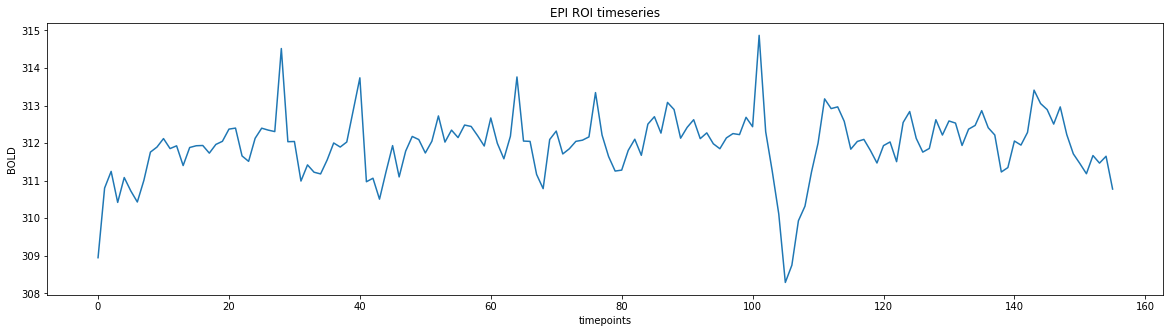

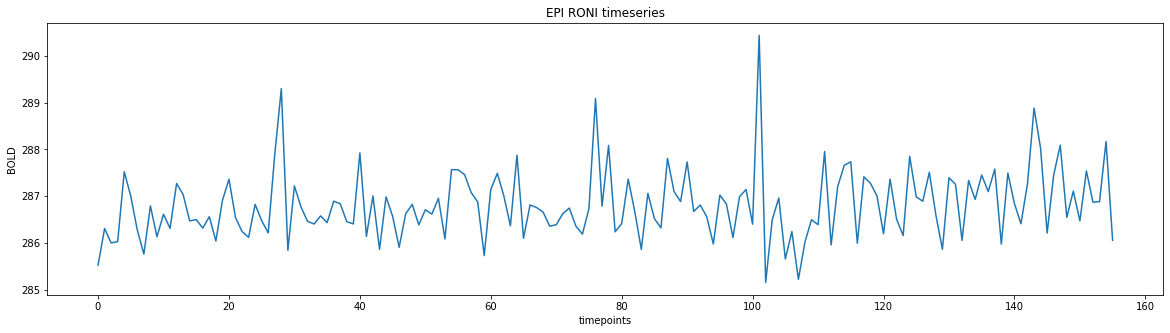

In [25]:
plot_timeseries(epi,gm,cf)

In [26]:
df_conf

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,Cosine00,Cosine01,Cosine02,NonSteadyStateOutlier00,X,Y,Z,RotX,RotY,RotZ
0,369.767471,311.736365,308.533095,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
1,372.552703,312.925149,310.304289,1.166953,22.459551,1.051636,0.108187,-0.052936,-0.099546,0.009943,...,0.113587,0.113569,0.113540,0.0,-0.000001,0.058839,0.010873,0.000071,-0.000588,-1.107130e-04
2,371.204701,313.054077,310.723328,1.206145,23.213856,1.090066,0.140320,-0.075490,0.062484,0.116962,...,0.113540,0.113382,0.113120,0.0,-0.000023,0.107766,-0.010354,-0.000746,-0.001083,-2.020460e-04
3,368.952166,311.828677,310.102972,1.259568,24.242050,1.081862,0.104449,0.092802,0.079894,-0.034276,...,0.113447,0.113010,0.112282,0.0,0.000045,0.109108,-0.047783,-0.000056,-0.000662,-6.617440e-24
4,371.060184,313.993087,310.886506,1.235478,23.778416,1.074163,0.129960,-0.089944,-0.110499,-0.034538,...,0.113307,0.112451,0.111030,0.0,0.000043,0.026197,-0.009823,-0.000229,-0.000671,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,373.533686,313.329407,310.835882,1.461313,28.124912,1.079900,0.092972,-0.057336,-0.089837,-0.011172,...,-0.113120,0.111708,-0.109367,0.0,0.047715,-0.071441,-0.029830,-0.005245,0.000545,1.284010e-03
152,374.275375,312.957538,311.120221,1.430051,27.523232,0.983005,0.105690,0.072442,0.119010,0.054689,...,-0.113307,0.112451,-0.111030,0.0,0.047732,-0.040368,-0.061209,-0.004904,0.000045,1.261170e-03
153,372.265181,313.055874,310.939060,1.186910,22.843662,0.992270,0.148762,-0.132682,-0.011366,-0.063772,...,-0.113447,0.113010,-0.112282,0.0,0.017068,-0.090892,-0.043720,-0.005404,0.000503,1.304580e-03
154,379.114706,314.150589,311.330281,1.329378,25.585634,0.977246,0.103902,0.058340,-0.108741,0.178620,...,-0.113540,0.113382,-0.113120,0.0,0.017010,-0.133749,-0.037971,-0.004528,0.000675,1.360880e-03


Text(0.5, 1.0, "['aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05']")

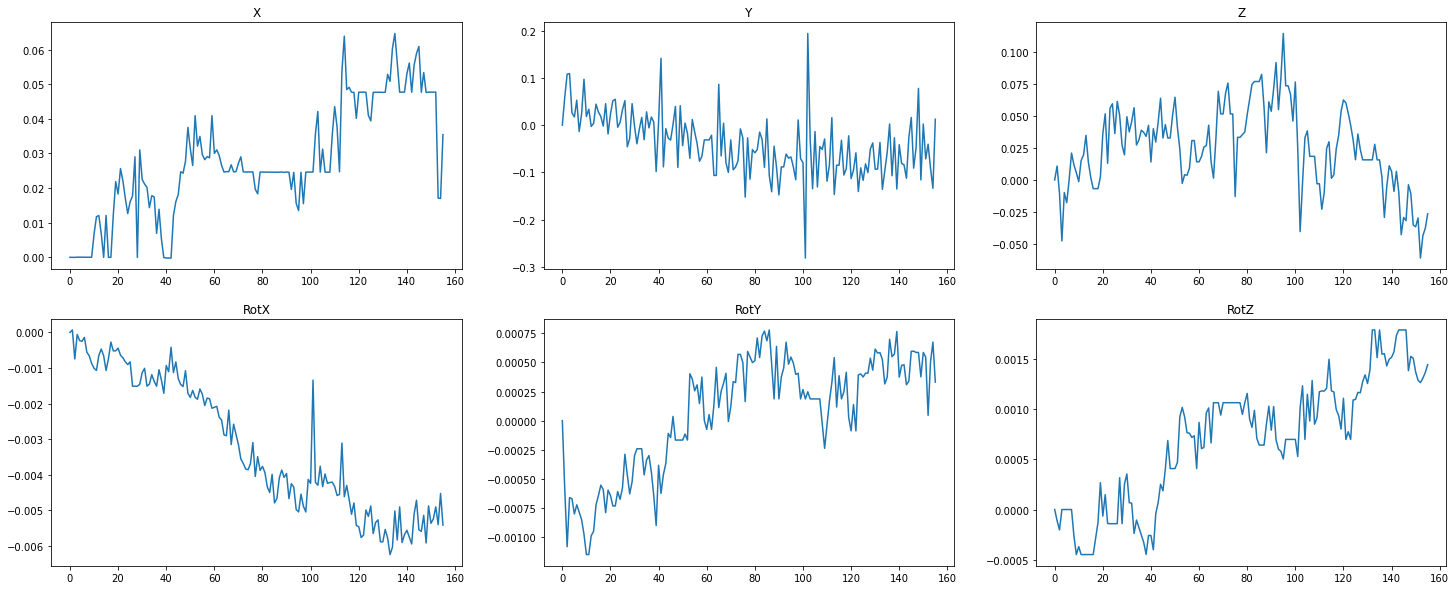

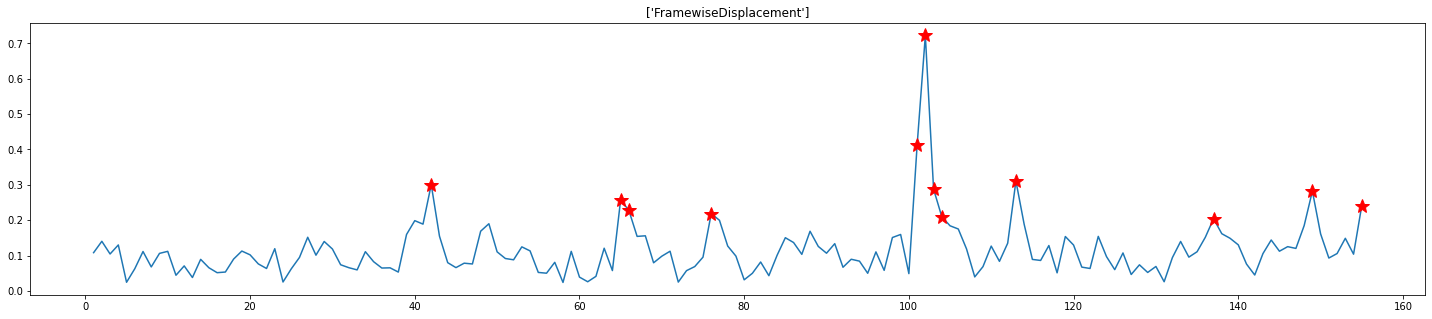

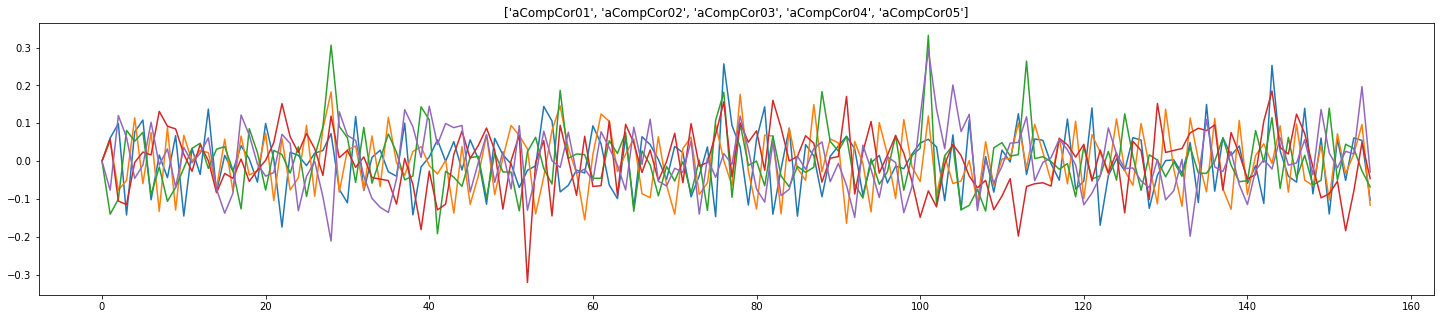

In [27]:
#conf_keys = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
conf_keys = ['X','Y','Z','RotX','RotY','RotZ']
plt.figure(figsize=(25,10))
nrows = 2
ncols = 3
sp=0
for key in conf_keys:
    sp=sp+1;plt.subplot(nrows,ncols,sp)
    plt.plot(df_conf[key].values)
    plt.title(key)
    
plt.figure(figsize=(25,5))
#conf_keys = ['framewise_displacement']
conf_keys = ['FramewiseDisplacement']
plt.plot(df_conf[conf_keys].values)
thresh=.2
vec = (df_conf[conf_keys].values>thresh)*1.0*df_conf[conf_keys].values
vec[vec==0]=np.nan
plt.plot(vec,'r*',markersize=15)
plt.title(conf_keys)

plt.figure(figsize=(25,5))
#conf_keys = ['a_comp_cor_01','a_comp_cor_02',  'a_comp_cor_03',  'a_comp_cor_04','a_comp_cor_05']
conf_keys = ['aCompCor01','aCompCor02',  'aCompCor03',  'aCompCor04','aCompCor05']
plt.plot(df_conf[conf_keys].values)
plt.title(conf_keys)

In [28]:
obs_list_coords,noi_list_coords,gm,cf = get_obs_noi_list_coords(epi,gm,cf)

obs_list_coords.shape: (41712, 4, 156)
noi_list_coords.shape: (9354, 4, 156)
upsampling noi_list_coords
obs_list_coords.shape: (41712, 4, 156)
noi_list_coords.shape: (41712, 4, 156)


In [29]:
assert np.isnan(obs_list_coords).sum()==0, 'NaNs in obs_list_coords'
assert np.isnan(noi_list_coords).sum()==0, 'NaNs in noi_list_coords'
assert (obs_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in obs_list_coords'
assert (noi_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in noi_list_coords'

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

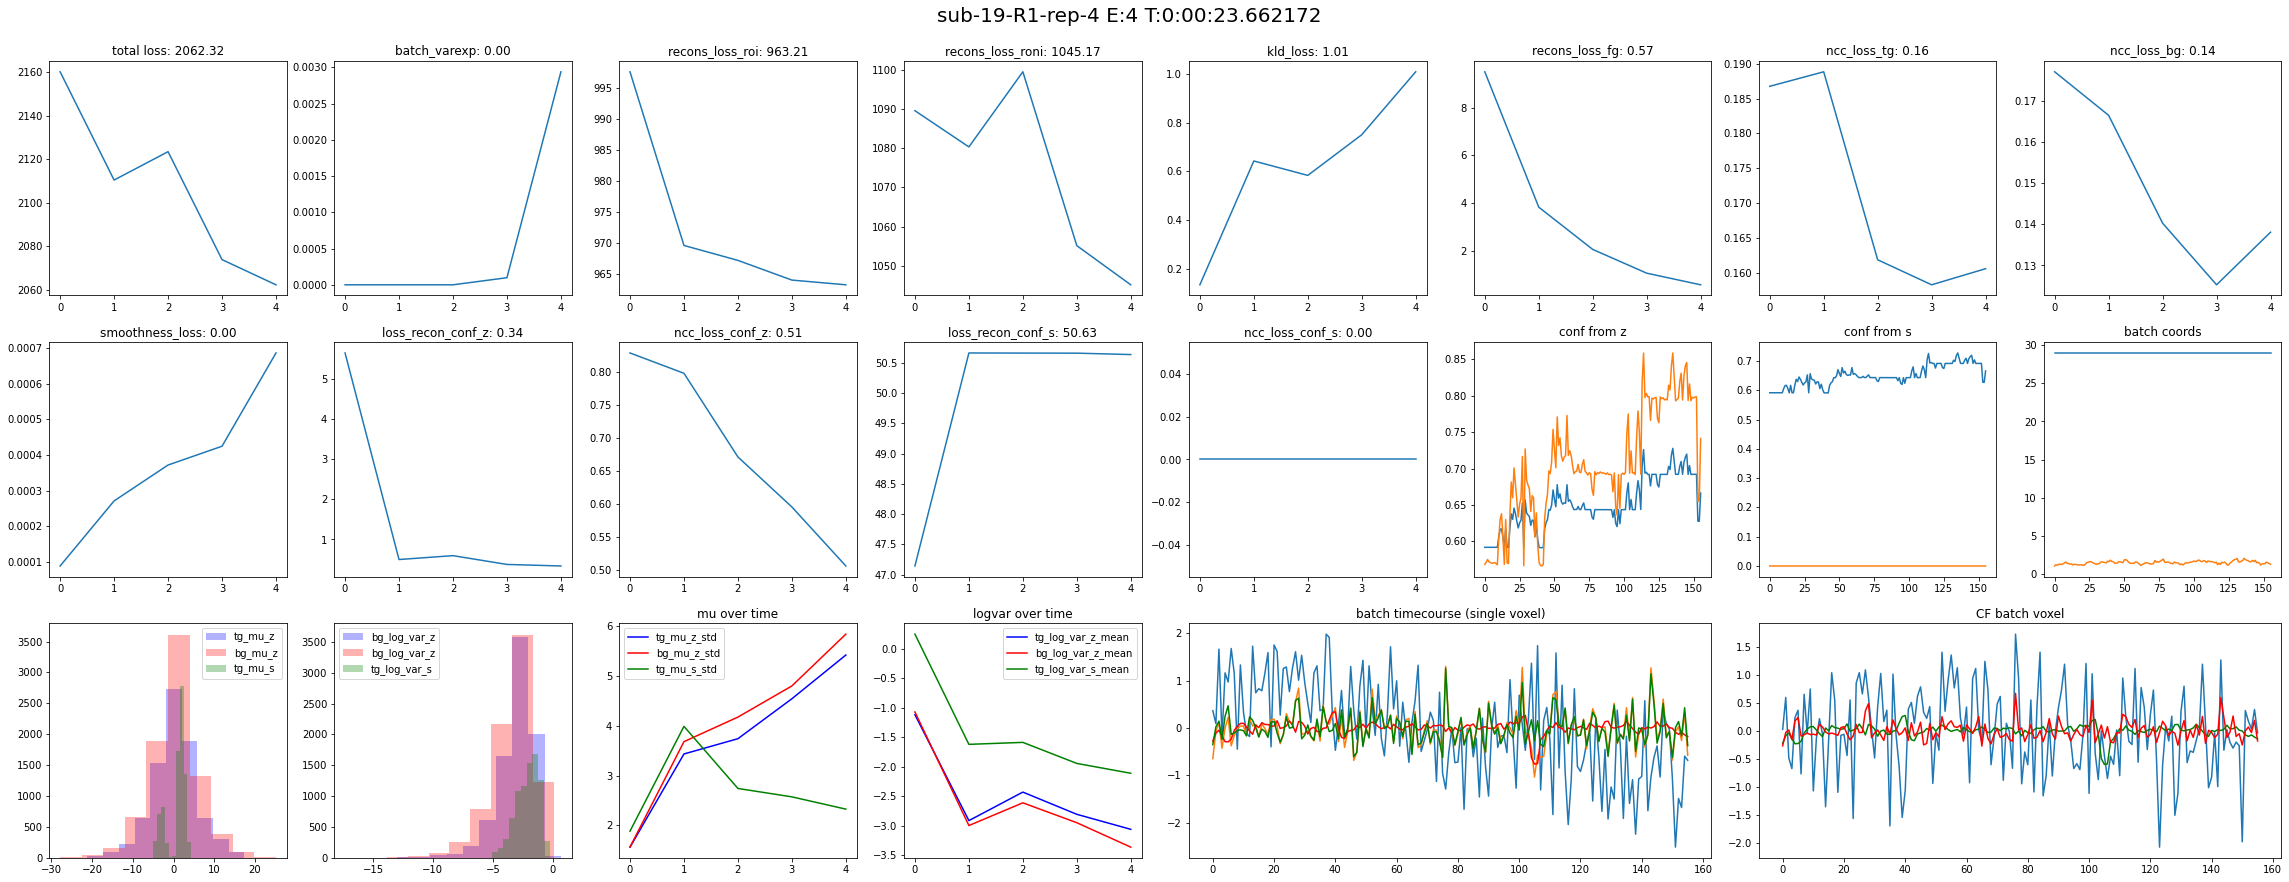

100%|██████████| 5/5 [02:26<00:00, 29.25s/it]

done training
[]


In [30]:
import traceback

nrep = hyperparams_cvae.get('nrep',20)
epoch_num = hyperparams_cvae.get('epoch_num',100)
batch_size = hyperparams_cvae.get('batch_size',512)
latent_dim = hyperparams_cvae.get('latent_dim',(8,8))
beta = hyperparams_cvae.get('beta',0.01)       
gamma = hyperparams_cvae.get('gamma',0)       
delta = hyperparams_cvae.get('delta',0)       
scale_MSE_GM = hyperparams_cvae.get('scale_MSE_GM',1e3)       
scale_MSE_CF = hyperparams_cvae.get('scale_MSE_CF',1e3)      
scale_MSE_FG = hyperparams_cvae.get('scale_MSE_FG',0) # "Denoised should be similar to input" scaling
lr = hyperparams_cvae.get('lr',0.001)

print(f'nrep: {nrep}')
print(f'epoch_num: {epoch_num}')
print(f'batch_size: {batch_size}')
print(f'latent_dim: {latent_dim}')
print(f'beta: {beta}')
print(f'gamma: {gamma}')
print(f'delta: {delta}')
print(f'scale_MSE_GM: {scale_MSE_GM}')
print(f'scale_MSE_CF: {scale_MSE_CF}')
print(f'scale_MSE_FG: {scale_MSE_FG}')
print(f'lr: {lr}')

train_inputs_coords = TrainDataset(obs_list_coords,noi_list_coords)
train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')
Tensor = TypeVar('torch.tensor')
conf_batch = torch.tensor(np.array([conf for _ in range(batch_size)])).to(device)

keys = ['l', 'kld_loss', 'recons_loss_roi', 'recons_loss_roni',
       'loss_recon_conf_s', 'loss_recon_conf_z', 'ncc_loss_tg',
       'ncc_loss_bg', 'ncc_loss_conf_s', 'ncc_loss_conf_z',
       'smoothness_loss', 'recons_loss_fg', 'r_ffa_reg', 'r_compcor_reg',
       'r_TG_reg', 'r_FG_reg', 'r_BG_reg', 'varexp', 'batch_varexp',
       'ffa_io', 'tg_mu_z', 'tg_log_var_z', 'tg_mu_s', 'tg_log_var_s',
       'tg_z', 'tg_s', 'bg_log_var_z', 'bg_mu_z','tg_log_var_z_mean','bg_log_var_z_mean','tg_log_var_s_mean','tg_mu_z_std','bg_mu_z_std','tg_mu_s_std','batch_signal',
'batch_noise',
'batch_in',
'batch_out',
'batch_varexp',
'confounds_pred_z',
'confounds_pred_s',
'mse_conf_z',
'mse_conf_s',]


track = init_track(keys)
errors = []

for rep in tqdm(range(nrep)):
    try:
        track = init_track(keys)
        track_ofn = os.path.join(ofdir,f'track_S{s}_R{r}_rep_{rep}.pickle')
        model_ofn = os.path.join(ofdir,f'model_S{s}_R{r}_rep_{rep}.pickle')
        
        model = cVAE(conf_batch,4,nTR,latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,freq_exp=0,freq_scale=0,do_disentangle=True)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)
        
        for epoch in range(epoch_num):  # loop over the dataset multiple times    
            model.train()
            dataloader_iter_in = iter(train_in_coords)
            for i in range(len(train_in_coords)):
                optimizer.zero_grad()
                inputs_gm,inputs_cf = next(dataloader_iter_in)

                inputs_gm = inputs_gm.float().to(device)
                inputs_cf = inputs_cf.float().to(device)

                [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
                [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)

                loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)

                if np.isnan(loss['loss'].detach().cpu().numpy()): raise ValueError(f'{rep}|{epoch}|{i}: loss is NaN')
                    
                loss['loss'].backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Prevent gradient explosion
                optimizer.step()
                
            track = update_track(track)
            show_bashboard(track,single_fig=True)
            
        save_model(model_ofn)
        save_track(track_ofn)
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'signal_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='FG')
        #save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'recon_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='TG') # Optional to save reconstructions
        #save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'noise_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='BG') # Optional to save noise estimates       
                            
    except:
        errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
        traceback.print_exc()
print('done training')
print(errors)

In [31]:
def array_to_brain(arr,epi,gm,ofn,inv_z_score=True,return_img=False):
    nTR = epi.shape[-1]
    epi_flat = epi.numpy().reshape(-1,nTR)
    gm_flat = gm.numpy().flatten()

    if inv_z_score==True:
        epi_mean = epi_flat[gm_flat==1,:].mean(axis=1)
        epi_std = epi_flat[gm_flat==1,:].std(axis=1)
        arr = (arr*epi_std[:,np.newaxis]+epi_mean[:,np.newaxis]) # Invert z-scoring

    assert arr.shape[0]==int(gm.numpy().sum()), f'shape mismatch: arr {arr.shape[0]}, GM {int(gm.numpy().sum())}'

    brain_signals_arr = np.zeros(epi_flat.shape)
    brain_signals_arr[gm_flat==1,:] = arr
    brain_signals_arr = brain_signals_arr.reshape(epi.shape)
    brain_signals_arr = epi.new_image_like(brain_signals_arr)
    brain_signals_arr.to_filename(ofn)
    
    if return_img==True:
        return brain_signals_arr

In [32]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [33]:
signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith('signal_'),f.endswith('.nii.gz')))]
track_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith('track_'),f.endswith('.pickle')))] 
signal_files.sort()
track_files.sort()

In [34]:
print(len(signal_files))

5


In [35]:
def average_signal_ensemble(signal_files,ofn):
    c = 0
    signal_avg = np.zeros(epi.shape)
    for signal_file in tqdm(signal_files):
        im = ants.image_read(signal_file)
        arr = im.numpy()
        if all([np.isnan(arr).sum()==0,np.max(arr)<1e3,np.max(arr)>1e-3]): # QA: only average if there arent NaNs in the ouputand the model hadn't collapsed or exploded
            signal_avg+=arr
            c+=1
    signal_avg = signal_avg/c # average
    #signal_avg = signal_avg*epi.numpy().std(axis=-1)[:,:,:,np.newaxis]+epi.numpy().mean(axis=-1)[:,:,:,np.newaxis] # inv Scale
    print(f'signals averaged: {c}')
    im = epi.new_image_like(signal_avg)
    im.to_filename(ofn)
    return im

In [36]:
signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'signal_S{s}_R{r}_avg.nii.gz'))

100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


signals averaged: 5


In [37]:
def calc_and_save_compcor(epi,gm,cf,ofn,n_components=5,return_img=False,do_center=True):
    from sklearn.decomposition import PCA
    from sklearn import linear_model

    n_components=5

    nTR = epi.shape[-1]
    epi_flat = epi.numpy().reshape(-1,nTR)
    
    if do_center==True:
        std0 = epi_flat.std(axis=-1)<1e-3
        epi_flat[~std0,:] = (epi_flat[~std0,:]-epi_flat[~std0,:].mean(axis=-1)[:,np.newaxis])/epi_flat[~std0,:].std(axis=-1)[:,np.newaxis] # Z-score the data
        epi_flat[std0,:]=0

    gm_flat = gm.numpy().flatten()
    cf_flat = cf.numpy().flatten()

    epi_cf = epi_flat[cf_flat==1,:].transpose()
    epi_gm = epi_flat[gm_flat==1,:].transpose()

    conf_pcs = PCA(n_components=n_components).fit_transform(epi_cf)
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(conf_pcs,epi_gm);

    compcor = epi_gm-lin_reg.predict(conf_pcs)
    compcor = compcor.transpose()

    n_std0 = (compcor.std(axis=1)<1e-3).sum()
    if n_std0>0:
        print(f'n_std0:{n_std0}')
        
    if return_img==False:
        array_to_brain(compcor,epi,gm,ofn,inv_z_score=False,return_img=False)
    else:
        img = array_to_brain(compcor,epi,gm,ofn,inv_z_score=False,return_img=True)
        return img 

In [38]:
array_to_brain(obs_list_coords[:,0,:],epi,gm,os.path.join(ofdir,f'preproc_S{s}_R{r}.nii.gz'),inv_z_score=True,return_img=False)

In [39]:
compcor = calc_and_save_compcor(epi,gm,cf,os.path.join(ofdir,f'compcor_S{s}_R{r}.nii.gz'),n_components=5,return_img=True)

In [40]:
def get_design_matrix(epi,events_fn):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn,delimiter='\t')

    t_r = np.round(epi.spacing[-1],2)
    nTR = epi.shape[-1]
    n_scans = nTR
    frame_times = (np.arange(n_scans) * t_r)
    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") 
    return X1

In [41]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [42]:
def calc_corr_map(im,mask,corr_target):

    mask_flat = mask.numpy().flatten()==1
    n = mask_flat.sum()
    im_flat = im.numpy().reshape(-1,im.shape[-1])

    r_vals = correlate_columns(im_flat[mask_flat,:].transpose(),np.array([corr_target for _ in range(n)]).transpose())

    res_flat = np.zeros(mask_flat.shape)
    res_flat[mask_flat]=r_vals
    
    temp_3d = im.slice_image(axis=-1,idx=0)
    res = res_flat.reshape(temp_3d.shape)
    
    res_nii = temp_3d.new_image_like(res)
    
    return res_nii

In [43]:
def get_contrast_val(Y,contrast_vec):
    
    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values
    
    contrast_values = beta @ contrast_vec

    return contrast_values

def calc_contrast_map(im,mask,contrast_vec):

    assert len(contrast_vec)==X1.shape[1], f'bad contrast shape. numel {len(contrast_vec)}: expected {X1.shape[1]}'
    assert sum(contrast_vec)==0, f'contrast does not sum to zero: sum={sum(contrast_vec)}'

    im_flat = im.numpy().reshape(-1,im.shape[-1])
    mask_flat = mask.numpy().flatten()==1
    n = mask_flat.sum()

    con_vals = get_contrast_val(im_flat[mask_flat,:],contrast_vec)

    res_flat = np.zeros(mask_flat.shape)
    res_flat[mask_flat]=con_vals

    temp_3d = im.slice_image(axis=-1,idx=0)
    res = res_flat.reshape(temp_3d.shape)

    res_nii = temp_3d.new_image_like(res)
    
    return res_nii

In [44]:
events_fn = os.path.join(f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv')
X1 = get_design_matrix(epi,events_fn)
X1

,body,face,house,object,scene,scramble,drift_1,drift_2,drift_3,constant
0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.500000,0.165591,-0.049036,1.0
2.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.493548,0.159181,-0.045240,1.0
4.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.487097,0.152855,-0.041567,1.0
6.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.480645,0.146611,-0.038015,1.0
8.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.474194,0.140451,-0.034584,1.0
...,...,...,...,...,...,...,...,...,...,...
302.0,0.0,0.0,0.0,0.0,-0.107050,0.0,0.474194,0.140451,0.034584,1.0
304.0,0.0,0.0,0.0,0.0,-0.143768,0.0,0.480645,0.146611,0.038015,1.0
306.0,0.0,0.0,0.0,0.0,-0.127186,0.0,0.487097,0.152855,0.041567,1.0
308.0,0.0,0.0,0.0,0.0,-0.091765,0.0,0.493548,0.159181,0.045240,1.0


In [45]:
# Calculate Corr Files: Face
corr_target = X1['face'].values
corr2face_preproc = calc_corr_map(epi,gm,corr_target)
corr2face_compcor = calc_corr_map(compcor,gm,corr_target)
corr2face_signal = calc_corr_map(signals_averaged,gm,corr_target)

# Save the Corr files
corr2face_preproc.to_filename(os.path.join(ofdir,f'corr2face_preproc_S{s}_R{r}.nii.gz'))
corr2face_compcor.to_filename(os.path.join(ofdir,f'corr2face_compcor_S{s}_R{r}.nii.gz'))
corr2face_signal.to_filename(os.path.join(ofdir,f'corr2face_signal_S{s}_R{r}.nii.gz'))

In [46]:
# Calculate Corr Files: Place
corr_target = X1[['house','scene']].values.mean(axis=1)
corr2place_preproc = calc_corr_map(epi,gm,corr_target)
corr2place_compcor = calc_corr_map(compcor,gm,corr_target)
corr2place_signal = calc_corr_map(signals_averaged,gm,corr_target)

# Save the Corr files
corr2place_preproc.to_filename(os.path.join(ofdir,f'corr2place_preproc_S{s}_R{r}.nii.gz'))
corr2place_compcor.to_filename(os.path.join(ofdir,f'corr2place_compcor_S{s}_R{r}.nii.gz'))
corr2place_signal.to_filename(os.path.join(ofdir,f'corr2place_signal_S{s}_R{r}.nii.gz'))

In [47]:
# Calculate Contrast Files: Face
contrast_vec = [-1,5,-1,-1,-1,-1,0,0,0,0]
contrast_face_preproc = calc_contrast_map(epi,gm,contrast_vec)
contrast_face_compcor = calc_contrast_map(compcor,gm,contrast_vec)
contrast_face_signal = calc_contrast_map(signals_averaged,gm,contrast_vec)

contrast_face_preproc.to_filename(os.path.join(ofdir,f'contrast_face_preproc{s}_R{r}.nii.gz'))
contrast_face_compcor.to_filename(os.path.join(ofdir,f'contrast_face_compcor{s}_R{r}.nii.gz'))
contrast_face_signal.to_filename(os.path.join(ofdir,f'contrast_face_signal{s}_R{r}.nii.gz'))

In [48]:
# Calculate Contrast Files: Place
contrast_vec = [-1,-1,2,-1,2,-1,0,0,0,0]
contrast_place_preproc = calc_contrast_map(epi,gm,contrast_vec)
contrast_place_compcor = calc_contrast_map(compcor,gm,contrast_vec)
contrast_place_signal = calc_contrast_map(signals_averaged,gm,contrast_vec)

contrast_place_preproc.to_filename(os.path.join(ofdir,f'contrast_place_preproc{s}_R{r}.nii.gz'))
contrast_place_compcor.to_filename(os.path.join(ofdir,f'contrast_place_compcor{s}_R{r}.nii.gz'))
contrast_place_signal.to_filename(os.path.join(ofdir,f'contrast_place_signal{s}_R{r}.nii.gz'))

Text(0.5, 0.98, 'FFA')

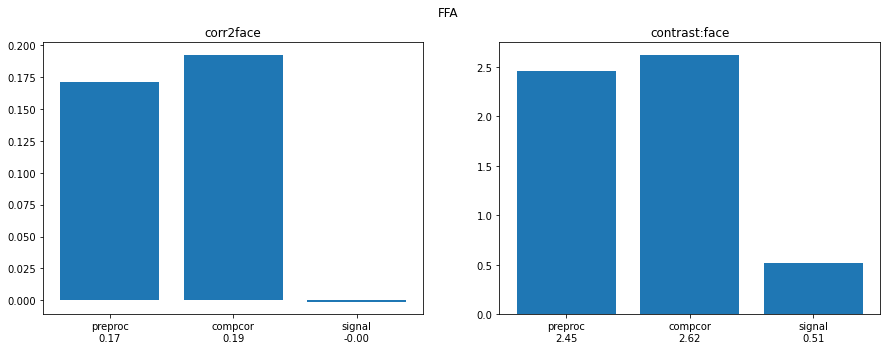

In [49]:
roi = ants.image_read(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
val1=corr2face_preproc.numpy()[roi.numpy()==1]
val2=corr2face_compcor.numpy()[roi.numpy()==1]
val3=corr2face_signal.numpy()[roi.numpy()==1]

ys = [val1.mean(),val2.mean(),val3.mean()];
xs = [0,1,2];
plt.bar(xs,ys);
plt.xticks(xs,labels=[f'preproc\n{ys[0]:.2f}',f'compcor\n{ys[1]:.2f}',f'signal\n{ys[2]:.2f}']);
plt.title('corr2face')

plt.subplot(1,2,2)
val1=contrast_face_preproc.numpy()[roi.numpy()==1]
val2=contrast_face_compcor.numpy()[roi.numpy()==1]
val3=contrast_face_signal.numpy()[roi.numpy()==1]

ys = [val1.mean(),val2.mean(),val3.mean()];
xs = [0,1,2];
plt.bar(xs,ys);
plt.xticks(xs,labels=[f'preproc\n{ys[0]:.2f}',f'compcor\n{ys[1]:.2f}',f'signal\n{ys[2]:.2f}']);
plt.title('contrast:face')

plt.suptitle('FFA')

Text(0.5, 0.98, 'PPA')

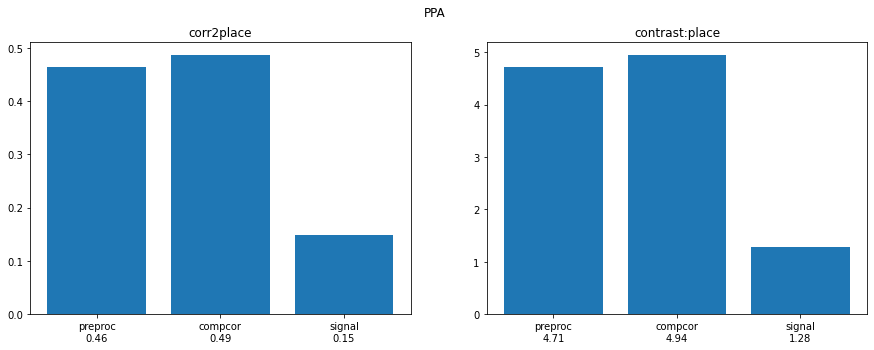

In [50]:
roi = ants.image_read(f'../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
val1=corr2place_preproc.numpy()[roi.numpy()==1]
val2=corr2place_compcor.numpy()[roi.numpy()==1]
val3=corr2place_signal.numpy()[roi.numpy()==1]

ys = [val1.mean(),val2.mean(),val3.mean()];
xs = [0,1,2];
plt.bar(xs,ys);
plt.xticks(xs,labels=[f'preproc\n{ys[0]:.2f}',f'compcor\n{ys[1]:.2f}',f'signal\n{ys[2]:.2f}']);
plt.title('corr2place')

plt.subplot(1,2,2)
val1=contrast_place_preproc.numpy()[roi.numpy()==1]
val2=contrast_place_compcor.numpy()[roi.numpy()==1]
val3=contrast_place_signal.numpy()[roi.numpy()==1]

ys = [val1.mean(),val2.mean(),val3.mean()];
xs = [0,1,2];
plt.bar(xs,ys);
plt.xticks(xs,labels=[f'preproc\n{ys[0]:.2f}',f'compcor\n{ys[1]:.2f}',f'signal\n{ys[2]:.2f}']);
plt.title('contrast:place')

plt.suptitle('PPA')

In [51]:
tracks = [load_pickle(track_file) for track_file in track_files]

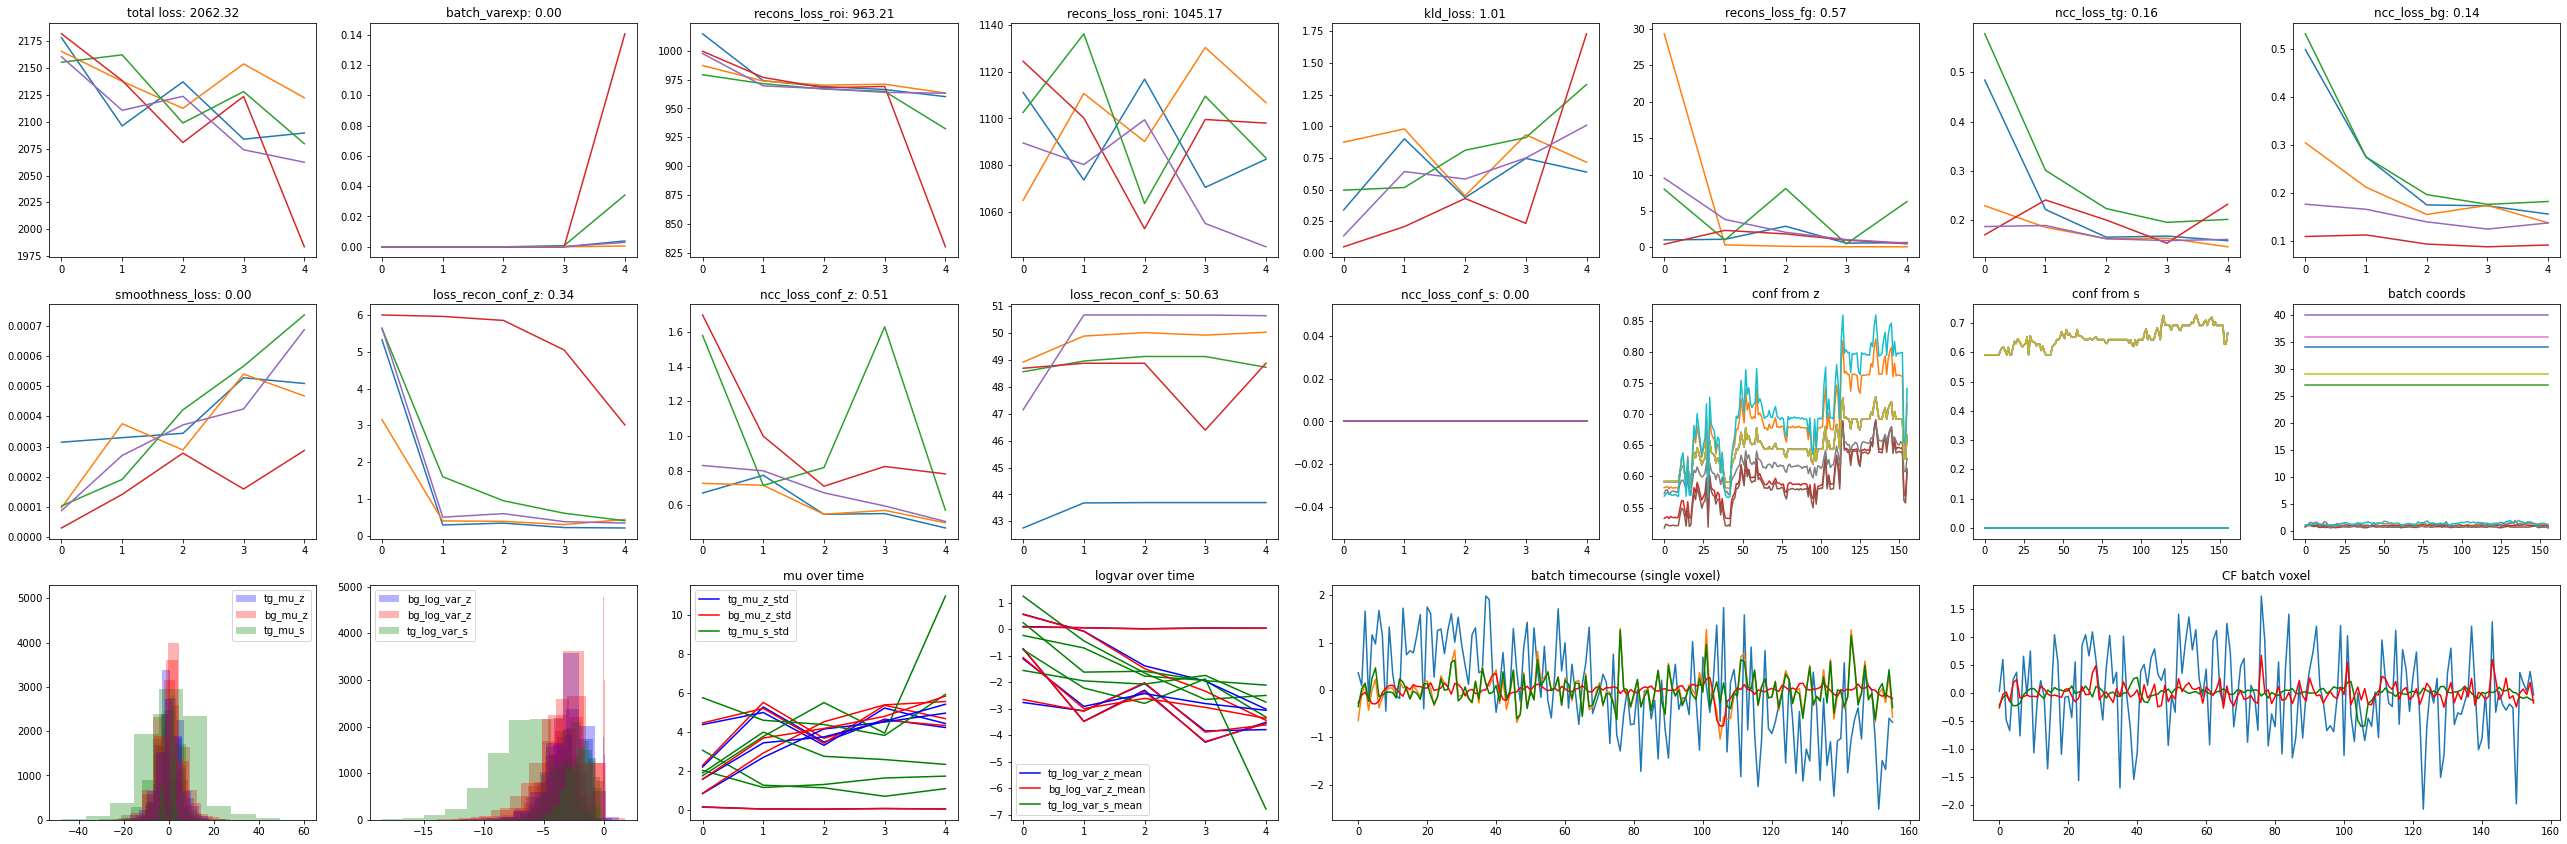

In [52]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(5*9,5*5))
for track in tracks:
    try:
        show_bashboard(track,single_fig=False)
    except:
        print('bad track')